## MERSCOPE MENDER-UMAP
### Reproduction of Figure 4H
UMAP embedding on the top of MENDER cellular context representation on a mouse brain atlas using MERSCOPE.

In [ ]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import MENDER as mender

from utils.data_loader import DataLoader

In [2]:
# Load MERSCOPE Dataset from SODB
loader = DataLoader("Dataset13_MS_raw")
adata_dict = loader.load()
adata = list(adata_dict.values())[0]

Loading dataset: Dataset13_MS_raw
load experiment[Dataset13] in dataset[Dataset13_MS_raw]
Dataset loaded successfully.


In [3]:
# Copy the raw data for later use
adata_raw = adata.copy()

In [4]:
batch_obs = 'slice_id'

In [5]:
# Run MENDER
msm = mender.MENDER(
    adata=adata,
    batch_obs=batch_obs,    # Use slice info
    ct_obs='ct',            # Use the cell state got by Leiden
    random_seed=666
)

msm.prepare()

In [6]:
# Set parameters for MENDER
msm.set_MENDER_para(
    nn_mode='radius',
    nn_para=15,         # Radius in microns
    n_scales=6,         # Number of scales to build
    count_rep='s',      # Single-scale frequency count
    include_self=True   # Include the cell itself in its neighborhood count
)

In [7]:
# Extract multi-scale context representation
msm.run_representation_mp(mp=2)     # Use 8 parallel processes

default number of process is 200


In [8]:
# Run clustering on the context representation
# Positive values for the expected number of domains
# Negative values for the clustering resolution
msm.run_clustering_normal(target_k=-1.5)

In [9]:
# Run UMAP
adata = msm.adata_MENDER

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata.obsm['X_MENDERMAP2D'] = adata.obsm['X_umap']

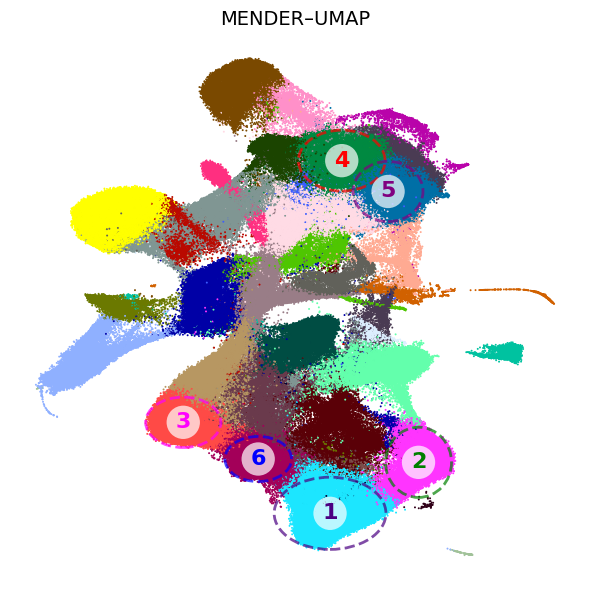

In [ ]:

# Create plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot UMAP embedding colored by MENDER clusters
sc.pl.embedding(
    adata,
    basis='X_MENDERMAP2D',
    color='MENDER',
    size=8,
    frameon=False,
    ax=ax,
    show=False,
    legend_loc=None
)

# Final polish
ax.set_title("MENDER–UMAP", fontsize=14)
ax.axis('off')
plt.tight_layout()

# Save to file
plt.savefig("plots/figure_4H_clean.png", dpi=300)
plt.show()